In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc, rcParams
rc('axes', linewidth=5)

from remat.core.dfgraph import gen_linear_graph
from experiments.common.load_keras_model import get_keras_model
from remat.core.solvers.strategy_checkpoint_all import solve_checkpoint_all
from remat.tensorflow2.extraction import dfgraph_from_keras
from remat.core.solvers.strategy_chen import solve_chen_sqrtn, solve_chen_greedy
from remat.core.solvers.strategy_optimal_ilp import solve_ilp_gurobi
from remat.core.solvers.strategy_griewank import solve_griewank

sns.set('talk')
sns.set_style('white')
RED = "#e74c3c"
BLUE = "#3498db"
flatui = [RED, BLUE, "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)

g = gen_linear_graph(32)
scheduler_result_all = solve_checkpoint_all(g)
scheduler_result = solve_griewank(g, 7)

data = []
compute_so_far = 0
for idx, (mem_step, sched_item) in enumerate(zip(scheduler_result_all.schedule_aux_data.mem_timeline, scheduler_result_all.schedule)):
    if 'OperatorEvaluation' in str(type(sched_item)):
        compute_so_far += sched_item.operator_cost
        data.append({'Time': compute_so_far, 'Solver': 'Retain all\nactivations', 'Total memory consumed': (mem_step - g.cost_ram_fixed) * 0.85})
data.pop()
data.append({'Time': compute_so_far + 15, 'Solver': 'Retain all\nactivations', 'Total memory consumed': data[-1]['Total memory consumed']})
no_remat_done_timestep = compute_so_far + 15    
    
from collections import defaultdict
when_computed = defaultdict(list)
for idx, sched_item in enumerate(scheduler_result.schedule):
    if 'OperatorEvaluation' in str(type(sched_item)):
        when_computed[sched_item.id].append(idx)
        
compute_so_far = 0
remat_cpu_range = []
remat_is_rematerialized = []
remat_ram_range = []
for idx, (mem_step, sched_item) in enumerate(zip(scheduler_result.schedule_aux_data.mem_timeline, scheduler_result.schedule)):
    if 'OperatorEvaluation' in str(type(sched_item)):
        compute_so_far += sched_item.operator_cost
        data.append({'Time': compute_so_far, 'Solver': 'Rematerialize\nactivations', 'Total memory consumed': mem_step - g.cost_ram_fixed})
        remat_is_rematerialized.append(idx != when_computed[sched_item.id][0])
        remat_cpu_range.append(compute_so_far)
        remat_ram_range.append(mem_step - g.cost_ram_fixed)
remat_done_timestep = compute_so_far
df = pd.DataFrame(data)

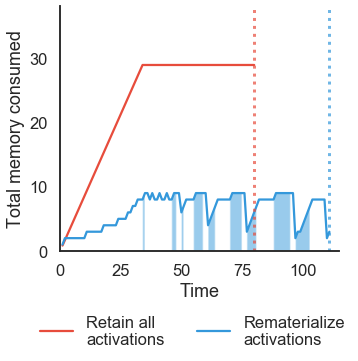

In [2]:
plt.figure(figsize=(5, 5))
plot = sns.lineplot(x='Time', y='Total memory consumed', hue='Solver', data=df)

plt.axvline(no_remat_done_timestep, color=RED, linestyle='dotted', alpha=0.7, linewidth=3)
plt.axvline(remat_done_timestep, color=BLUE, linestyle='dotted', alpha=0.7, linewidth=3)

ax = plot.axes
ax.margins(x=0, y=0)
ax.set_xlim(0, 115)
ax.set_ylim(0, 38)

ax.fill_between(remat_cpu_range, 0, remat_ram_range, where=remat_is_rematerialized, facecolor='#3498db', alpha=0.5)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='best', fancybox=False, title=None, frameon=False, handles=handles[1:], labels=labels[1:],
          ncol=2, bbox_to_anchor=(1.075, -0.2))
plt.savefig('timeline.pdf', bbox_inches='tight')

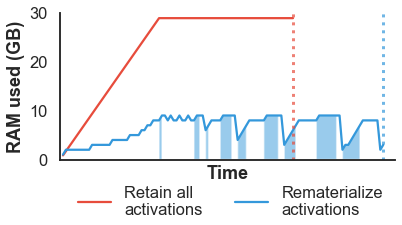

In [11]:
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = '18'

plt.figure(figsize=(6, 3))
plot = sns.lineplot(x='Time', y='Total memory consumed', hue='Solver', data=df)
plt.ylabel("RAM used (GB)")
plt.xlabel("Time", labelpad=5)
plt.axvline(no_remat_done_timestep, color=RED, linestyle='dotted', alpha=0.7, linewidth=3)
plt.axvline(remat_done_timestep, color=BLUE, linestyle='dotted', alpha=0.7, linewidth=3)

ax = plot.axes
ax.margins(x=0, y=0)
ax.set_xlim(0, 115)
ax.set_ylim(0, 30)
plt.xticks([])

ax.fill_between(remat_cpu_range, 0, remat_ram_range, where=remat_is_rematerialized, facecolor='#3498db', alpha=0.5)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='best', fancybox=False, title=None, frameon=False, handles=handles[1:], labels=labels[1:],
          ncol=2, bbox_to_anchor=(.99, -0.12), borderpad=0)
plt.margins(0,0)
plt.savefig('timeline.pdf', bbox_inches='tight', pad_inches=0)